In [5]:
!pip install pandas numpy matplotlib scikit-learn statsmodels tensorflow keras

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam


In [7]:
temp_data = pd.read_csv("/content/US_City_Temp_Data.csv")

In [8]:
temp_data = pd.read_csv("US_City_Temp_Data.csv")
temp_data['time'] = pd.to_datetime(temp_data['time'])

In [9]:
print(temp_data.info())
print(temp_data.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 899 entries, 0 to 898
Data columns (total 36 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   time            899 non-null    datetime64[ns]
 1   albuquerque     899 non-null    float64       
 2   anchorage       899 non-null    float64       
 3   atlanta         899 non-null    float64       
 4   boise           899 non-null    float64       
 5   boston          899 non-null    float64       
 6   buffalo         899 non-null    float64       
 7   charlotte       899 non-null    float64       
 8   chicago         899 non-null    float64       
 9   dallas          899 non-null    float64       
 10  denver          899 non-null    float64       
 11  detroit         899 non-null    float64       
 12  helena          899 non-null    float64       
 13  honolulu        899 non-null    float64       
 14  indianapolis    899 non-null    float64       
 15  jackso

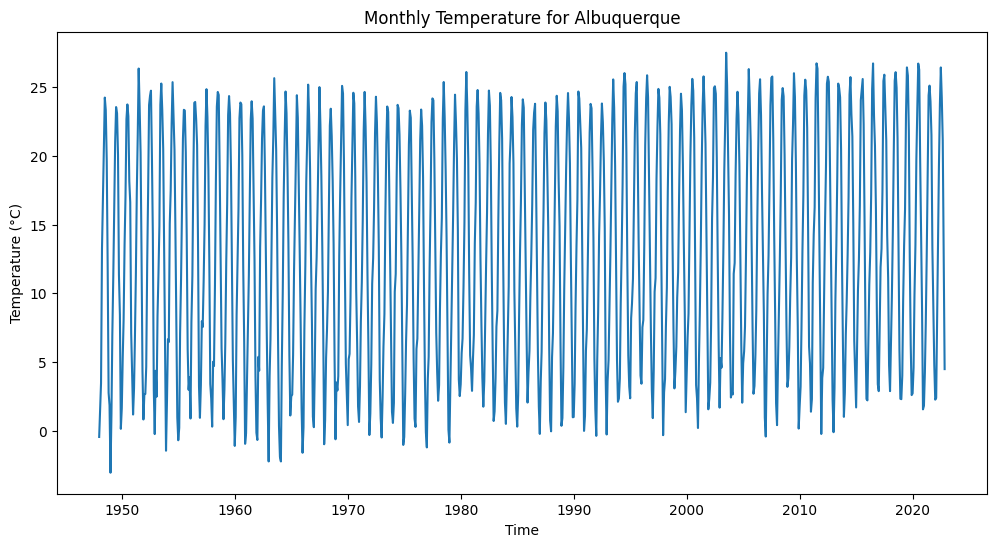

In [10]:
# Select data for Albuquerque
city_data = temp_data[['time', 'albuquerque']].dropna()
city_data.set_index('time', inplace=True)

# Plot the time series
plt.figure(figsize=(12, 6))
plt.plot(city_data.index, city_data['albuquerque'])
plt.title("Monthly Temperature for Albuquerque")
plt.ylabel("Temperature (°C)")
plt.xlabel("Time")
plt.show()

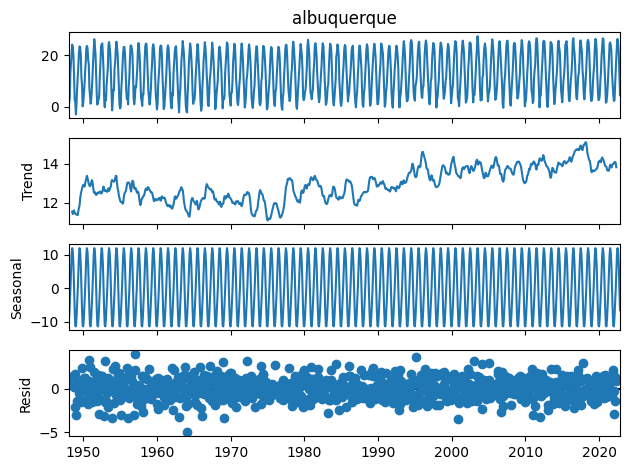

In [11]:
# Decompose the time series
decomposed = seasonal_decompose(city_data['albuquerque'], model='additive', period=12)
decomposed.plot()
plt.tight_layout()
plt.show()


In [12]:
def adf_test(series):
    result = adfuller(series)
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    print('Critical Values:')
    for key, value in result[4].items():
        print(f'\t{key}: {value}')

# Perform ADF test
adf_test(city_data['albuquerque'])

ADF Statistic: -3.2513043809942173
p-value: 0.01720053095520928
Critical Values:
	1%: -3.4378283848659277
	5%: -2.864841231335243
	10%: -2.5685278140988053


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:            albuquerque   No. Observations:                  899
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -2364.740
Date:                Sun, 08 Dec 2024   AIC                           4735.480
Time:                        15:44:12   BIC                           4749.881
Sample:                    01-01-1948   HQIC                          4740.982
                         - 11-01-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6279      0.039     16.092      0.000       0.551       0.704
ma.L1          0.1177      0.050      2.370      0.018       0.020       0.215
sigma2        11.3390      0.627     18.083      0.0

<ipython-input-13-63e311eac5fd>:10: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  plt.plot(pd.date_range(start=city_data.index[-1], periods=13, freq='M')[1:], forecast, label='Forecast')


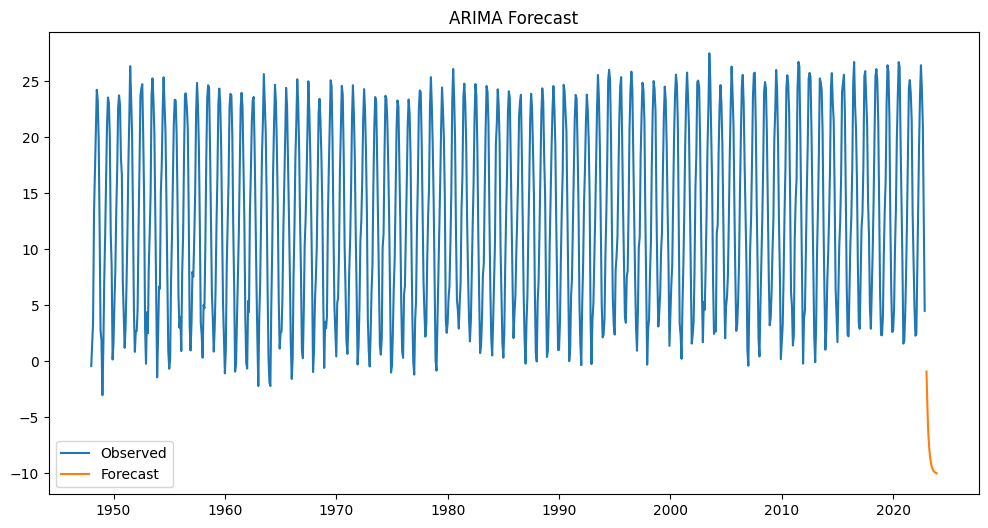

In [13]:
# Fit ARIMA model
model = ARIMA(city_data['albuquerque'], order=(1,1,1))
results = model.fit()
print(results.summary())

# Forecast
forecast = results.forecast(steps=12)
plt.figure(figsize=(12, 6))
plt.plot(city_data.index, city_data['albuquerque'], label='Observed')
plt.plot(pd.date_range(start=city_data.index[-1], periods=13, freq='M')[1:], forecast, label='Forecast')
plt.title('ARIMA Forecast')
plt.legend()
plt.show()

In [14]:
# Scale the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(city_data[['albuquerque']])

# Reshape data for LSTM
X_train = scaled_data.reshape((len(scaled_data), 1, 1))
Y_train = scaled_data

# Define LSTM model
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(1, 1)),
    LSTM(50, return_sequences=False),
    Dense(1)
])

# Compile model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train model
history = model.fit(X_train, Y_train, epochs=50, batch_size=32, validation_split=0.2, verbose=1)

# Make predictions
lstm_predictions = model.predict(X_train)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 8s 91ms/step - loss: 0.9180 - val_loss: 0.8666
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.7783 - val_loss: 0.6096
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.4966 - val_loss: 0.2312
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.1359 - val_loss: 0.0111
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0030 - val_loss: 0.0022
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0016 - val_loss: 0.0012
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 5.6458e-04 - val_loss: 6.0846e-04
Epoch 8/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 4.5297e-04 - val_loss: 5.6733e-04
Epoch 9/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 4.0129e-04 - val_loss: 5.1514e-04
Epoch 10/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 3.9653e-04 - val_loss: 5.3301e-04
Epoch 11/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.1523e-04 - val_loss: 4.9374e-04
Epoch 12/50
23/23 ━━━━━━━━

In [15]:
from sklearn.metrics import mean_squared_error
import math

# Unscale LSTM predictions
unscaled_predictions = scaler.inverse_transform(lstm_predictions).flatten()

# Calculate RMSE for ARIMA
arima_rmse = math.sqrt(mean_squared_error(city_data['albuquerque'][-12:], forecast))
print(f"ARIMA RMSE: {arima_rmse}")

# Calculate RMSE for LSTM
lstm_rmse = math.sqrt(mean_squared_error(city_data['albuquerque'], unscaled_predictions))
print(f"LSTM RMSE: {lstm_rmse}")

# Hybrid model
hybrid_predictions = (forecast.values + unscaled_predictions[-12:]) / 2
hybrid_rmse = math.sqrt(mean_squared_error(city_data['albuquerque'][-12:], hybrid_predictions))
print(f"Hybrid RMSE: {hybrid_rmse}")

ARIMA RMSE: 24.14068530672941
LSTM RMSE: 0.04225442619992462
Hybrid RMSE: 12.077435960422585


In [16]:
total_rmse = arima_rmse + lstm_rmse
lstm_weight = 1 - (lstm_rmse / total_rmse)
arima_weight = 1 - (arima_rmse / total_rmse)

# Normalize weights to sum to 1
sum_weights = lstm_weight + arima_weight
lstm_weight = lstm_weight / sum_weights
arima_weight = arima_weight / sum_weights

print(f"LSTM Weight: {lstm_weight:.4f}")
print(f"ARIMA Weight: {arima_weight:.4f}")

# Weighted hybrid model
hybrid_predictions = (arima_weight * forecast.values +
                     lstm_weight * unscaled_predictions[-12:])

# Calculate RMSE for weighted hybrid
hybrid_rmse = math.sqrt(mean_squared_error(city_data['albuquerque'][-12:],
                                         hybrid_predictions))
print(f"Weighted Hybrid RMSE: {hybrid_rmse}")

LSTM Weight: 0.9983
ARIMA Weight: 0.0017
Weighted Hybrid RMSE: 0.07127871392496708


<ipython-input-17-d7fa32016731>:4: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  plt.plot(pd.date_range(start=city_data.index[-1], periods=13, freq='M')[1:], forecast, label='ARIMA')
<ipython-input-17-d7fa32016731>:5: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  plt.plot(pd.date_range(start=city_data.index[-1], periods=13, freq='M')[1:], hybrid_predictions, label='Hybrid')


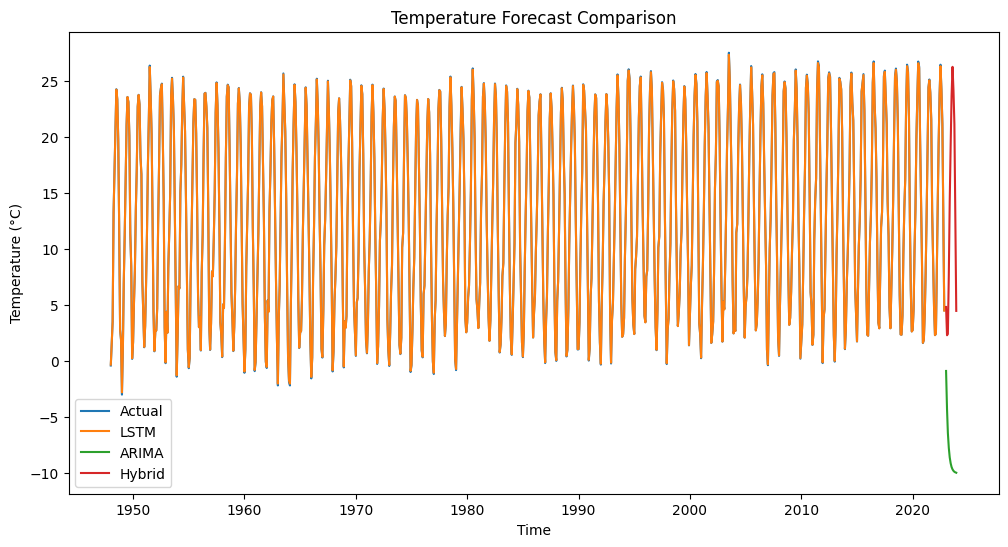

In [17]:
plt.figure(figsize=(12, 6))
plt.plot(city_data.index, city_data['albuquerque'], label='Actual')
plt.plot(city_data.index, unscaled_predictions, label='LSTM')
plt.plot(pd.date_range(start=city_data.index[-1], periods=13, freq='M')[1:], forecast, label='ARIMA')
plt.plot(pd.date_range(start=city_data.index[-1], periods=13, freq='M')[1:], hybrid_predictions, label='Hybrid')
plt.title('Temperature Forecast Comparison')
plt.xlabel('Time')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.show()

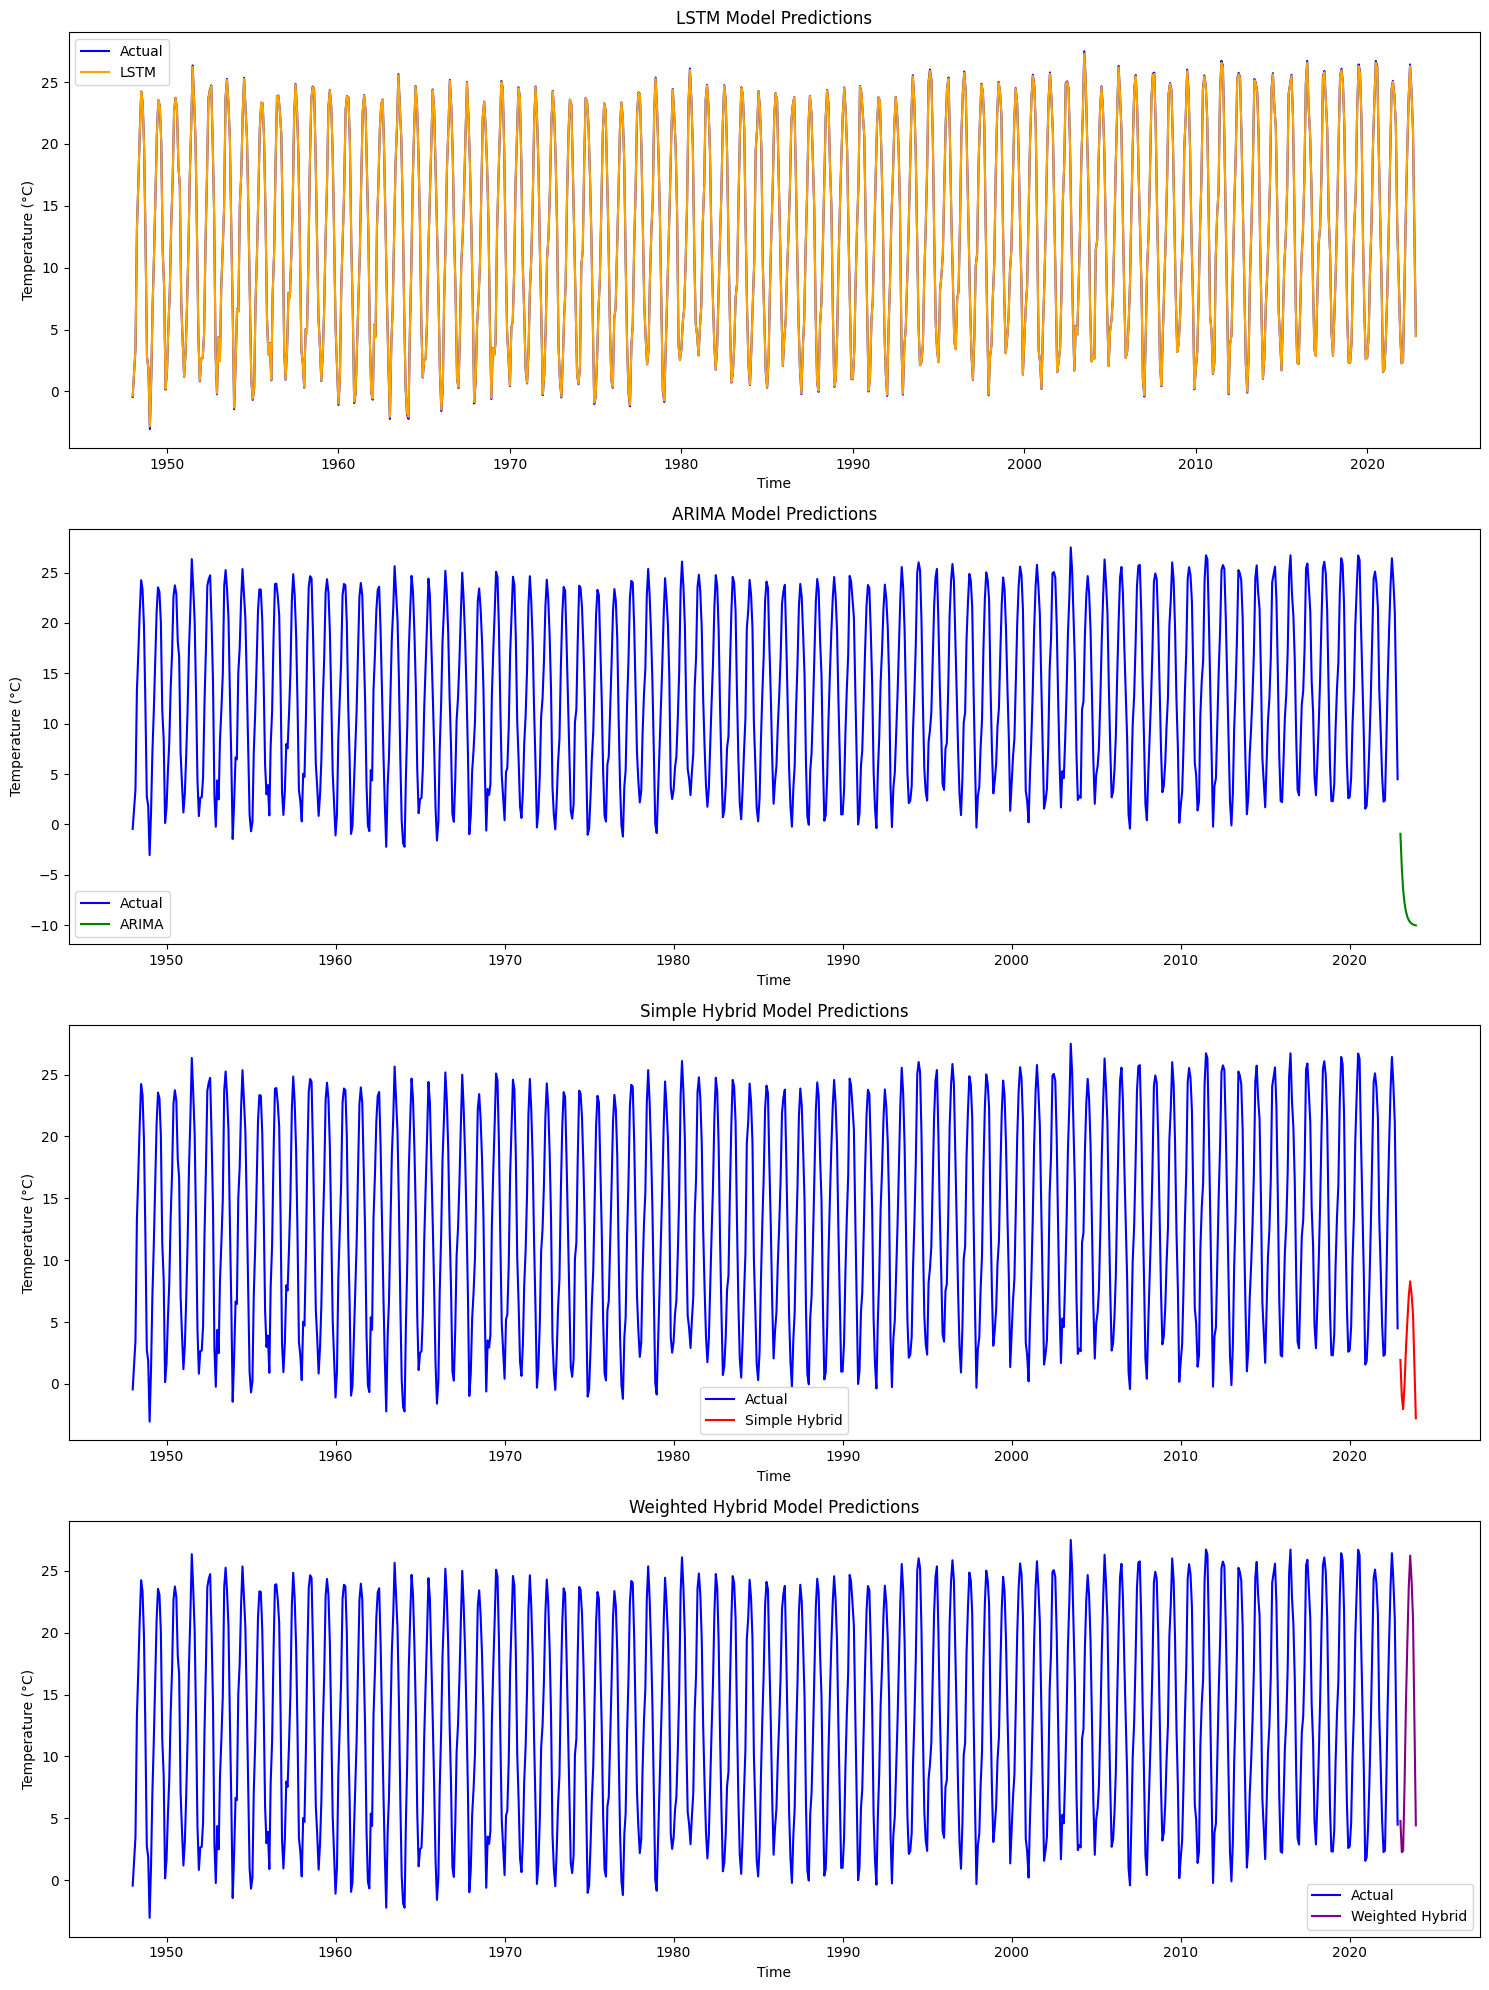


Model Performance Metrics:
LSTM RMSE: 0.0423
ARIMA RMSE: 24.1407
Simple Hybrid RMSE: 12.0774
Weighted Hybrid RMSE: 0.0713

Model Weights:
LSTM Weight: 0.9983
ARIMA Weight: 0.0017


In [19]:
import matplotlib.pyplot as plt

# Create a figure with subplots
plt.figure(figsize=(15, 20))

# Plot 1: LSTM Predictions
plt.subplot(4, 1, 1)
plt.plot(city_data.index, city_data['albuquerque'], label='Actual', color='blue')
plt.plot(city_data.index, unscaled_predictions, label='LSTM', color='orange')
plt.title('LSTM Model Predictions')
plt.xlabel('Time')
plt.ylabel('Temperature (°C)')
plt.legend()

# Plot 2: ARIMA Predictions
plt.subplot(4, 1, 2)
plt.plot(city_data.index, city_data['albuquerque'], label='Actual', color='blue')
plt.plot(pd.date_range(start=city_data.index[-1], periods=13, freq='ME')[1:],
         forecast, label='ARIMA', color='green')
plt.title('ARIMA Model Predictions')
plt.xlabel('Time')
plt.ylabel('Temperature (°C)')
plt.legend()

# Plot 3: Simple Hybrid Predictions
plt.subplot(4, 1, 3)
plt.plot(city_data.index, city_data['albuquerque'], label='Actual', color='blue')
plt.plot(pd.date_range(start=city_data.index[-1], periods=13, freq='ME')[1:],
         (forecast.values + unscaled_predictions[-12:]) / 2, label='Simple Hybrid', color='red')
plt.title('Simple Hybrid Model Predictions')
plt.xlabel('Time')
plt.ylabel('Temperature (°C)')
plt.legend()

# Plot 4: Weighted Hybrid Predictions
plt.subplot(4, 1, 4)
plt.plot(city_data.index, city_data['albuquerque'], label='Actual', color='blue')
plt.plot(pd.date_range(start=city_data.index[-1], periods=13, freq='ME')[1:],
         hybrid_predictions, label='Weighted Hybrid', color='purple')
plt.title('Weighted Hybrid Model Predictions')
plt.xlabel('Time')
plt.ylabel('Temperature (°C)')
plt.legend()

# Adjust layout
plt.tight_layout()
plt.show()

# Print model performance metrics
print("\nModel Performance Metrics:")
print(f"LSTM RMSE: {lstm_rmse:.4f}")
print(f"ARIMA RMSE: {arima_rmse:.4f}")
print(f"Simple Hybrid RMSE: {math.sqrt(mean_squared_error(city_data['albuquerque'][-12:], (forecast.values + unscaled_predictions[-12:]) / 2)):.4f}")
print(f"Weighted Hybrid RMSE: {hybrid_rmse:.4f}")
print(f"\nModel Weights:")
print(f"LSTM Weight: {lstm_weight:.4f}")
print(f"ARIMA Weight: {arima_weight:.4f}")

# New Section